In [1]:
#导入包以及设置随机种子
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)

                1
count  143.000000
mean   279.237762
std    119.708270
min    104.000000
25%    180.000000
50%    264.000000
75%    359.500000
max    622.000000


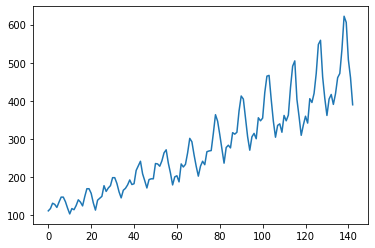

In [2]:
# 读取第二列数据
all_data  = pd.read_csv('./data.csv',usecols=[1],header=None)
# 数据可视化
print(all_data.describe())
plt.plot(all_data)

In [3]:
# 数据预处理
from sklearn.preprocessing import MinMaxScaler
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    
    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(all_data)

seq_length = 2
x, y = sliding_windows(training_data, seq_length)

#train_size = int(len(y) * 0.67)
#test_size = len(y) - train_size
# 使用143个月的数据训练 不划分训练集和测试集
dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

#trainX = torch.Tensor(np.array(x[0:train_size]))
#trainY = torch.Tensor(np.array(y[0:train_size]))

#testX = torch.Tensor(np.array(x[train_size:len(x)]))
#testY = torch.Tensor(np.array(y[train_size:len(y)]))

In [4]:
# 定义模型
class RNN(nn.Module):
    def __init__(self, rnn_layer, seq_length):
        super(RNN, self).__init__()
        self.rnn = rnn_layer
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.rnn.hidden_size*seq_length, 1)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.rnn.hidden_size*self.num_directions*seq_length, 1)
        
    def forward(self, x, state):
        out, state = self.rnn(x, state)
        output = self.linear(out.reshape(out.size(0), -1))
        return output, state
    
    def begin_state(self, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.rnn.hidden_size))
        else:
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.rnn.hidden_size)),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.rnn.hidden_size)))

In [5]:
num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1
multi_layers = 5


criterion = torch.nn.MSELoss()    # 定义损失函数

In [6]:
def train_model(model,
               criterion,
               x_train,
               y_train,
               epochs=1000):
    state = model.begin_state(x_train.size(0))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred,_ = model(x_train, state)
        
        # calculate the loss 
        error = criterion(pred,y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()

        
        
        
        if epoch % 100 == 0:
            print('Epoch :{}    Train Loss :{}'.format((epoch+1)/epochs, error.item()))
        # 测试模型
def test_model(model):
        model.eval()
        
        x = []
        for i in range(len(training_data)-seq_length+1):
            x.append(training_data[i:i+seq_length])
        testX = torch.Tensor(np.array(x))
        state = model.begin_state(testX.size(0))
        train_predict,_ = model(testX, state)

        data_predict = train_predict.detach().numpy()
        dataY_plot = dataY.data.numpy()

        data_predict = sc.inverse_transform(data_predict)
        dataY_plot = sc.inverse_transform(dataY_plot)

        # 数据可视化
        plt.plot(dataY_plot)
        # 蓝色是真实值
        plt.plot(data_predict)
        # 橘色是预测值
        plt.suptitle('Flight-passengers Prediction')
        # 增加图例
        plt.legend([ 'Real', 'Pred'])
        plt.show()
        print('第144个月的乘客人数为：%d k'%data_predict[-1])


Epoch :0.001    Train Loss :0.5984176397323608
Epoch :0.101    Train Loss :0.015965254977345467
Epoch :0.201    Train Loss :0.007403181865811348
Epoch :0.301    Train Loss :0.006499300245195627
Epoch :0.401    Train Loss :0.005177679937332869
Epoch :0.501    Train Loss :0.0041525657288730145
Epoch :0.601    Train Loss :0.0036877342499792576
Epoch :0.701    Train Loss :0.0035460556391626596
Epoch :0.801    Train Loss :0.003495206590741873
Epoch :0.901    Train Loss :0.0034570933785289526


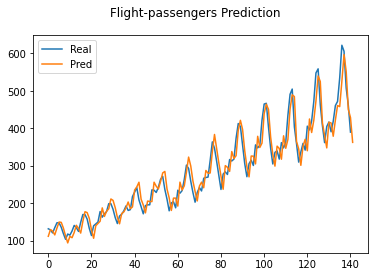

第144个月的乘客人数为：362 k


In [7]:
#单层GRU
gru = nn.GRU(input_size, hidden_size, num_layers, bidirectional=False, batch_first=True)
gru = RNN(gru, seq_length)
train_model(gru,criterion,dataX,dataY,epochs=num_epochs)
test_model(gru)

Epoch :0.001    Train Loss :0.05683647468686104
Epoch :0.101    Train Loss :0.00724596856161952
Epoch :0.201    Train Loss :0.004565367009490728
Epoch :0.301    Train Loss :0.0037141386419534683
Epoch :0.401    Train Loss :0.003526531858369708
Epoch :0.501    Train Loss :0.0034053726121783257
Epoch :0.601    Train Loss :0.0033071970101445913
Epoch :0.701    Train Loss :0.0032514003105461597
Epoch :0.801    Train Loss :0.0032178049441426992
Epoch :0.901    Train Loss :0.003189333714544773


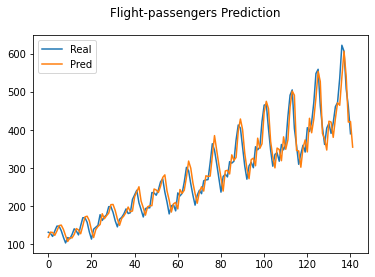

第144个月的乘客人数为：355 k


In [8]:
#单层LSTM
lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=False, batch_first=True)
lstm = RNN(lstm, seq_length)
train_model(lstm,criterion,dataX,dataY,epochs=num_epochs)
test_model(lstm)

Epoch :0.001    Train Loss :0.052483100444078445
Epoch :0.101    Train Loss :0.008916611783206463
Epoch :0.201    Train Loss :0.007121226284652948
Epoch :0.301    Train Loss :0.0031419096048921347
Epoch :0.401    Train Loss :0.0029838494956493378
Epoch :0.501    Train Loss :0.002872564597055316
Epoch :0.601    Train Loss :0.0027456111274659634
Epoch :0.701    Train Loss :0.002676616422832012
Epoch :0.801    Train Loss :0.002665245207026601
Epoch :0.901    Train Loss :0.002654187846928835


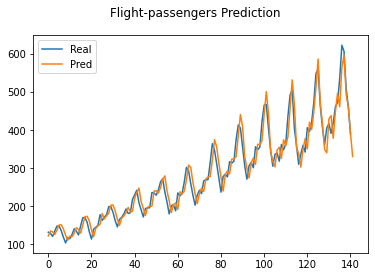

第144个月的乘客人数为：330 k


In [9]:
#多层LSTM
lstm_multi = nn.LSTM(input_size, hidden_size, multi_layers, bidirectional=False, batch_first=True)
lstm_multi = RNN(lstm_multi, seq_length)
train_model(lstm_multi,criterion,dataX,dataY,epochs=num_epochs)
test_model(lstm_multi)

Epoch :0.001    Train Loss :0.4734886586666107
Epoch :0.101    Train Loss :0.006585533730685711
Epoch :0.201    Train Loss :0.005902058910578489
Epoch :0.301    Train Loss :0.005274171940982342
Epoch :0.401    Train Loss :0.004303381312638521
Epoch :0.501    Train Loss :0.0035515925846993923
Epoch :0.601    Train Loss :0.0033249338157474995
Epoch :0.701    Train Loss :0.0032686314079910517
Epoch :0.801    Train Loss :0.0032344236969947815
Epoch :0.901    Train Loss :0.0032030069269239902


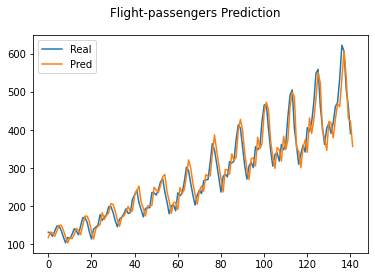

第144个月的乘客人数为：356 k


In [10]:
#双向LSTM
lstm_bi = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
lstm_bi = RNN(lstm_bi, seq_length)
train_model(lstm_bi,criterion,dataX,dataY,epochs=num_epochs)
test_model(lstm_bi)

Epoch :0.001    Train Loss :0.2148829996585846
Epoch :0.101    Train Loss :0.052319761365652084
Epoch :0.201    Train Loss :0.004975613206624985
Epoch :0.301    Train Loss :0.003116399049758911
Epoch :0.401    Train Loss :0.0029919669032096863
Epoch :0.501    Train Loss :0.002948447596281767
Epoch :0.601    Train Loss :0.0029033967293798923
Epoch :0.701    Train Loss :0.0028369140345603228
Epoch :0.801    Train Loss :0.0027644371148198843
Epoch :0.901    Train Loss :0.0026808890979737043


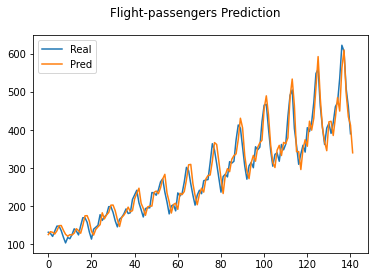

第144个月的乘客人数为：340 k


In [11]:
#多层双向LSTM
lstm_multi_bi = nn.LSTM(input_size, hidden_size, multi_layers, bidirectional=True, batch_first=True)
lstm_multi_bi = RNN(lstm_multi_bi, seq_length)
train_model(lstm_multi_bi,criterion,dataX,dataY,epochs=num_epochs)
test_model(lstm_multi_bi)